In [1]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

try:
    from plotting import plot_autoencoder_stats
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)

# Unsupservised Learning 

## Labelling Data is Expensive

In supervised machine learning, one aims at learning a mapping $f_{\psi} : \mathbf{x} \in \mathcal{R}^P \rightarrow \mathbf{y}$ from observations $\mathbf{x}$ to the target $\mathbf{y}$ using a dataset $\mathcal{D} = \{\mathbf{x}_i, \mathbf{y}_i\}_{i=1, \dots, N}$ of finite size N (e.g. image classification, translation). Because of the curse of dimensionality, high-dimensional inputs (images) and complex the models (deep learning) require large datasets (million of pairs $(\mathbf{x}, \mathbf{y})$). In practice, labelling data is expensive (e.g. marking the presence of cancer in X-ray chest scans). 

## Compression is Comprehension: Learning without Target

In order to overcome the curse of dimensionality, we aim at learning a compressed representation $\mathbf{z} \in \mathcal{R}^M$ of $\mathbf{x}$ such that $M < P$ and there is a mapping $g_{\phi}: \mathbf{x} \rightarrow \mathbf{z}$ linking each data point to its representation. Ideally, $\mathbf{z}$ is low-dimensional set of features which efficiently describes $\mathbf{x}$. As an illustration, when modelling pictures of celebrities (CelebA dataset), the set of facial features (eye color, age, hair lenth, etc.) is a compressed (and lossy) representation of $\mathbf{x}$. In practice, the representation  $\mathbf{z}$ is unobservable and [unlikely to overlap with such known features](https://arxiv.org/abs/1811.12359). Yet, the representation $\mathbf{z}$ is low dimensional and learning a mapping $f_{\psi} : \mathbf{z} \in \mathcal{R}^M \rightarrow \mathbf{y}$ is often easier.

Whereas labelling the data is expensive, observations $\mathbf{x}$ are cheap to acquire. In many cases, one can scrap the web to gather a large collection of images or text. As a result, large deep learning models can be deployed to learn $g_{\phi}$, and smaller / data-efficient models can be applied downstream to solve the supervised task.



# Auto-encoders: Compression as a Generation Process
In this notebook you will implement a simple auto-encoder (AE). We assume that you are already familiar with the basics of neural networks. We will start by defining an AE similar to the one used for the finetuning step by [Geoffrey Hinton and Ruslan Salakhutdinov](https://www.cs.toronto.edu/~hinton/science.pdf). We will experiment with the AE setup and try to run it on the MNIST dataset. There has been a wide variety of research into the field of auto-encoders and the technique that you are about to learn is very simple compared to modern methods: Masked Autoencoders ([MADE](https://arxiv.org/abs/1502.03509), [BERT](https://arxiv.org/abs/1810.04805)) and Variational Autoencoders ([VAE](https://arxiv.org/abs/1312.6114), [VQ-VAE](https://arxiv.org/abs/1711.00937), [BIVA](https://arxiv.org/abs/1902.02102), [NVAE](https://arxiv.org/abs/2007.03898)).

In unsupervised learning, we aim at learning compressed representations $\mathbf{z} \in \mathcal{P}$ of $\mathbf{x} \in \mathcal{R}$ where $ M < P$. The architecture of an autoencoder can be decomposed in two steps:

1. *Encoding* $\mathbf{x}$ into a low-dimensional representation $\mathbf{z}$ using a neural network $g_{\phi} : \mathbf{x} \rightarrow \mathbf{z}$.
2. *Decoding* the representation $\mathbf{z}$ into a reconstruction $\hat{\mathbf{x}} = h_\theta(\mathbf{z}) \in \mathcal{R}^P$.

Because $M < P$, the encoding acts as an information bottleneck: only part of the information describing $\mathbf{x}$ can be encoded into $\mathbf{z}$ as long as $M$ is sufficiently small.

Learning the parameters of the autoencoder relies on two aspects:

1. A distance in the observation space $d : \mathcal{R}^{P} \times \mathcal{R}^{P} \rightarrow \mathcal{R}$ (e.g. MSE), measuring the reconstruction quality.
2. Using backpropagation coupled with stochastic gradient descent (SGD) to optimize the parameters $\{\phi, \theta\}$ w.r.t $L := \frac{1}{N} \sum_i d(x_i, h_{\theta}(g_{\phi}(\mathbf{x})))$.

<img src="static/autoencoder.png" />

*The exercises are found at the bottom of the notebook*

## MNIST
First let us load the MNIST dataset and plot a few examples. In this notebook we will use the *dataloaders* and *datasets* provided by PyTorch. Defining the loading of datasets using a dataloader has the advantage that it only load the data that is *neccessary* into memory, which enables us to use very large scale datasets.

We only load a limited amount of classes defined by the `classes` variable to speed up training.

In [2]:
import torch
cuda = torch.cuda.is_available()

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Flatten the 2d-array image into a vector
flatten = lambda x: ToTensor()(x).view(28**2)

# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=flatten, download=True)
dset_test  = MNIST("./", train=False, transform=flatten)

# The digit classes to use
classes = [3, 7]

def stratified_sampler(labels, classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    from functools import reduce
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


# The loaders perform the actual work
batch_size = 64
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets, classes), pin_memory=cuda)
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.targets, classes), pin_memory=cuda)

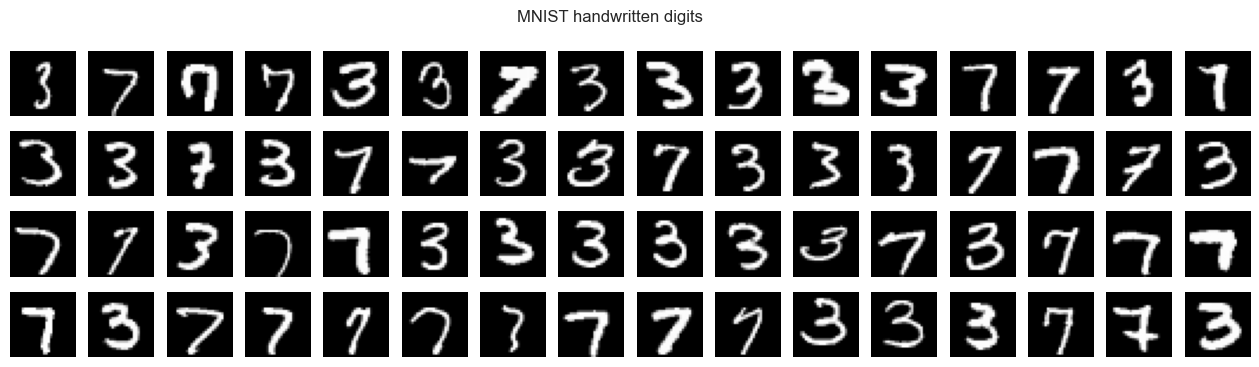

In [3]:
# Plot a batch of MNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

### Building the model
When defining the model the latent layer $z$ must act as a bottleneck of information. We initialize the AE with 1 hidden layer in the encoder and decoder using ReLU units as nonlinearities. The latent layer has a dimensionality of 2 in order to make it easy to visualise. Since $x$ are pixel intensities that are normalized between 0 and 1, we use the sigmoid nonlinearity to model the reconstruction.

In [4]:
import torch.nn as nn

# define size variables
num_features = 28*28

class AutoEncoder(nn.Module):
    def __init__(self, hidden_units, latent_features=2):
        super(AutoEncoder, self).__init__()
        # We typically employ an "hourglass" structure
        # meaning that the decoder should be an encoder
        # in reverse.
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units),
            nn.ReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units, out_features=latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units),
            nn.ReLU(),
            # output layer, projecting back to image size
            nn.Linear(in_features=hidden_units, out_features=num_features)
        )

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer
        z = self.encoder(x)
        
        # apply sigmoid to output to get pixel intensities between 0 and 1
        x_hat = torch.sigmoid(self.decoder(z))
        
        return {
            'z': z,
            'x_hat': x_hat
        }


# Choose the shape of the autoencoder
net = AutoEncoder(hidden_units=128, latent_features=2)

if cuda:
    net = net.cuda()

print(net)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
  )
)


Following we define the PyTorch functions for training and evaluation.

In [5]:
import torch.optim as optim

# if you want L2 regularization, then add weight_decay to SGD
optimizer = optim.SGD(net.parameters(), lr=0.25)

# We will use pixel wise mean-squared error as our loss function
loss_function = nn.MSELoss()

We can test the forward pass by checking whether the output shape is the same as the as the input.

In [6]:
# test the forward pass
# expect output size of [32, num_features]
x, y = next(iter(train_loader))
print(f"x.shape = {x.shape}")

if cuda:
    x = x.cuda()

outputs = net(x)
print(f"x_hat.shape = {outputs['x_hat'].shape}")


x.shape = torch.Size([64, 784])
x_hat.shape = torch.Size([64, 784])


In the training loop we sample each batch and evaluate the error, latent space, and reconstructions on every epoch.

**NOTE** this will take a while on CPU.

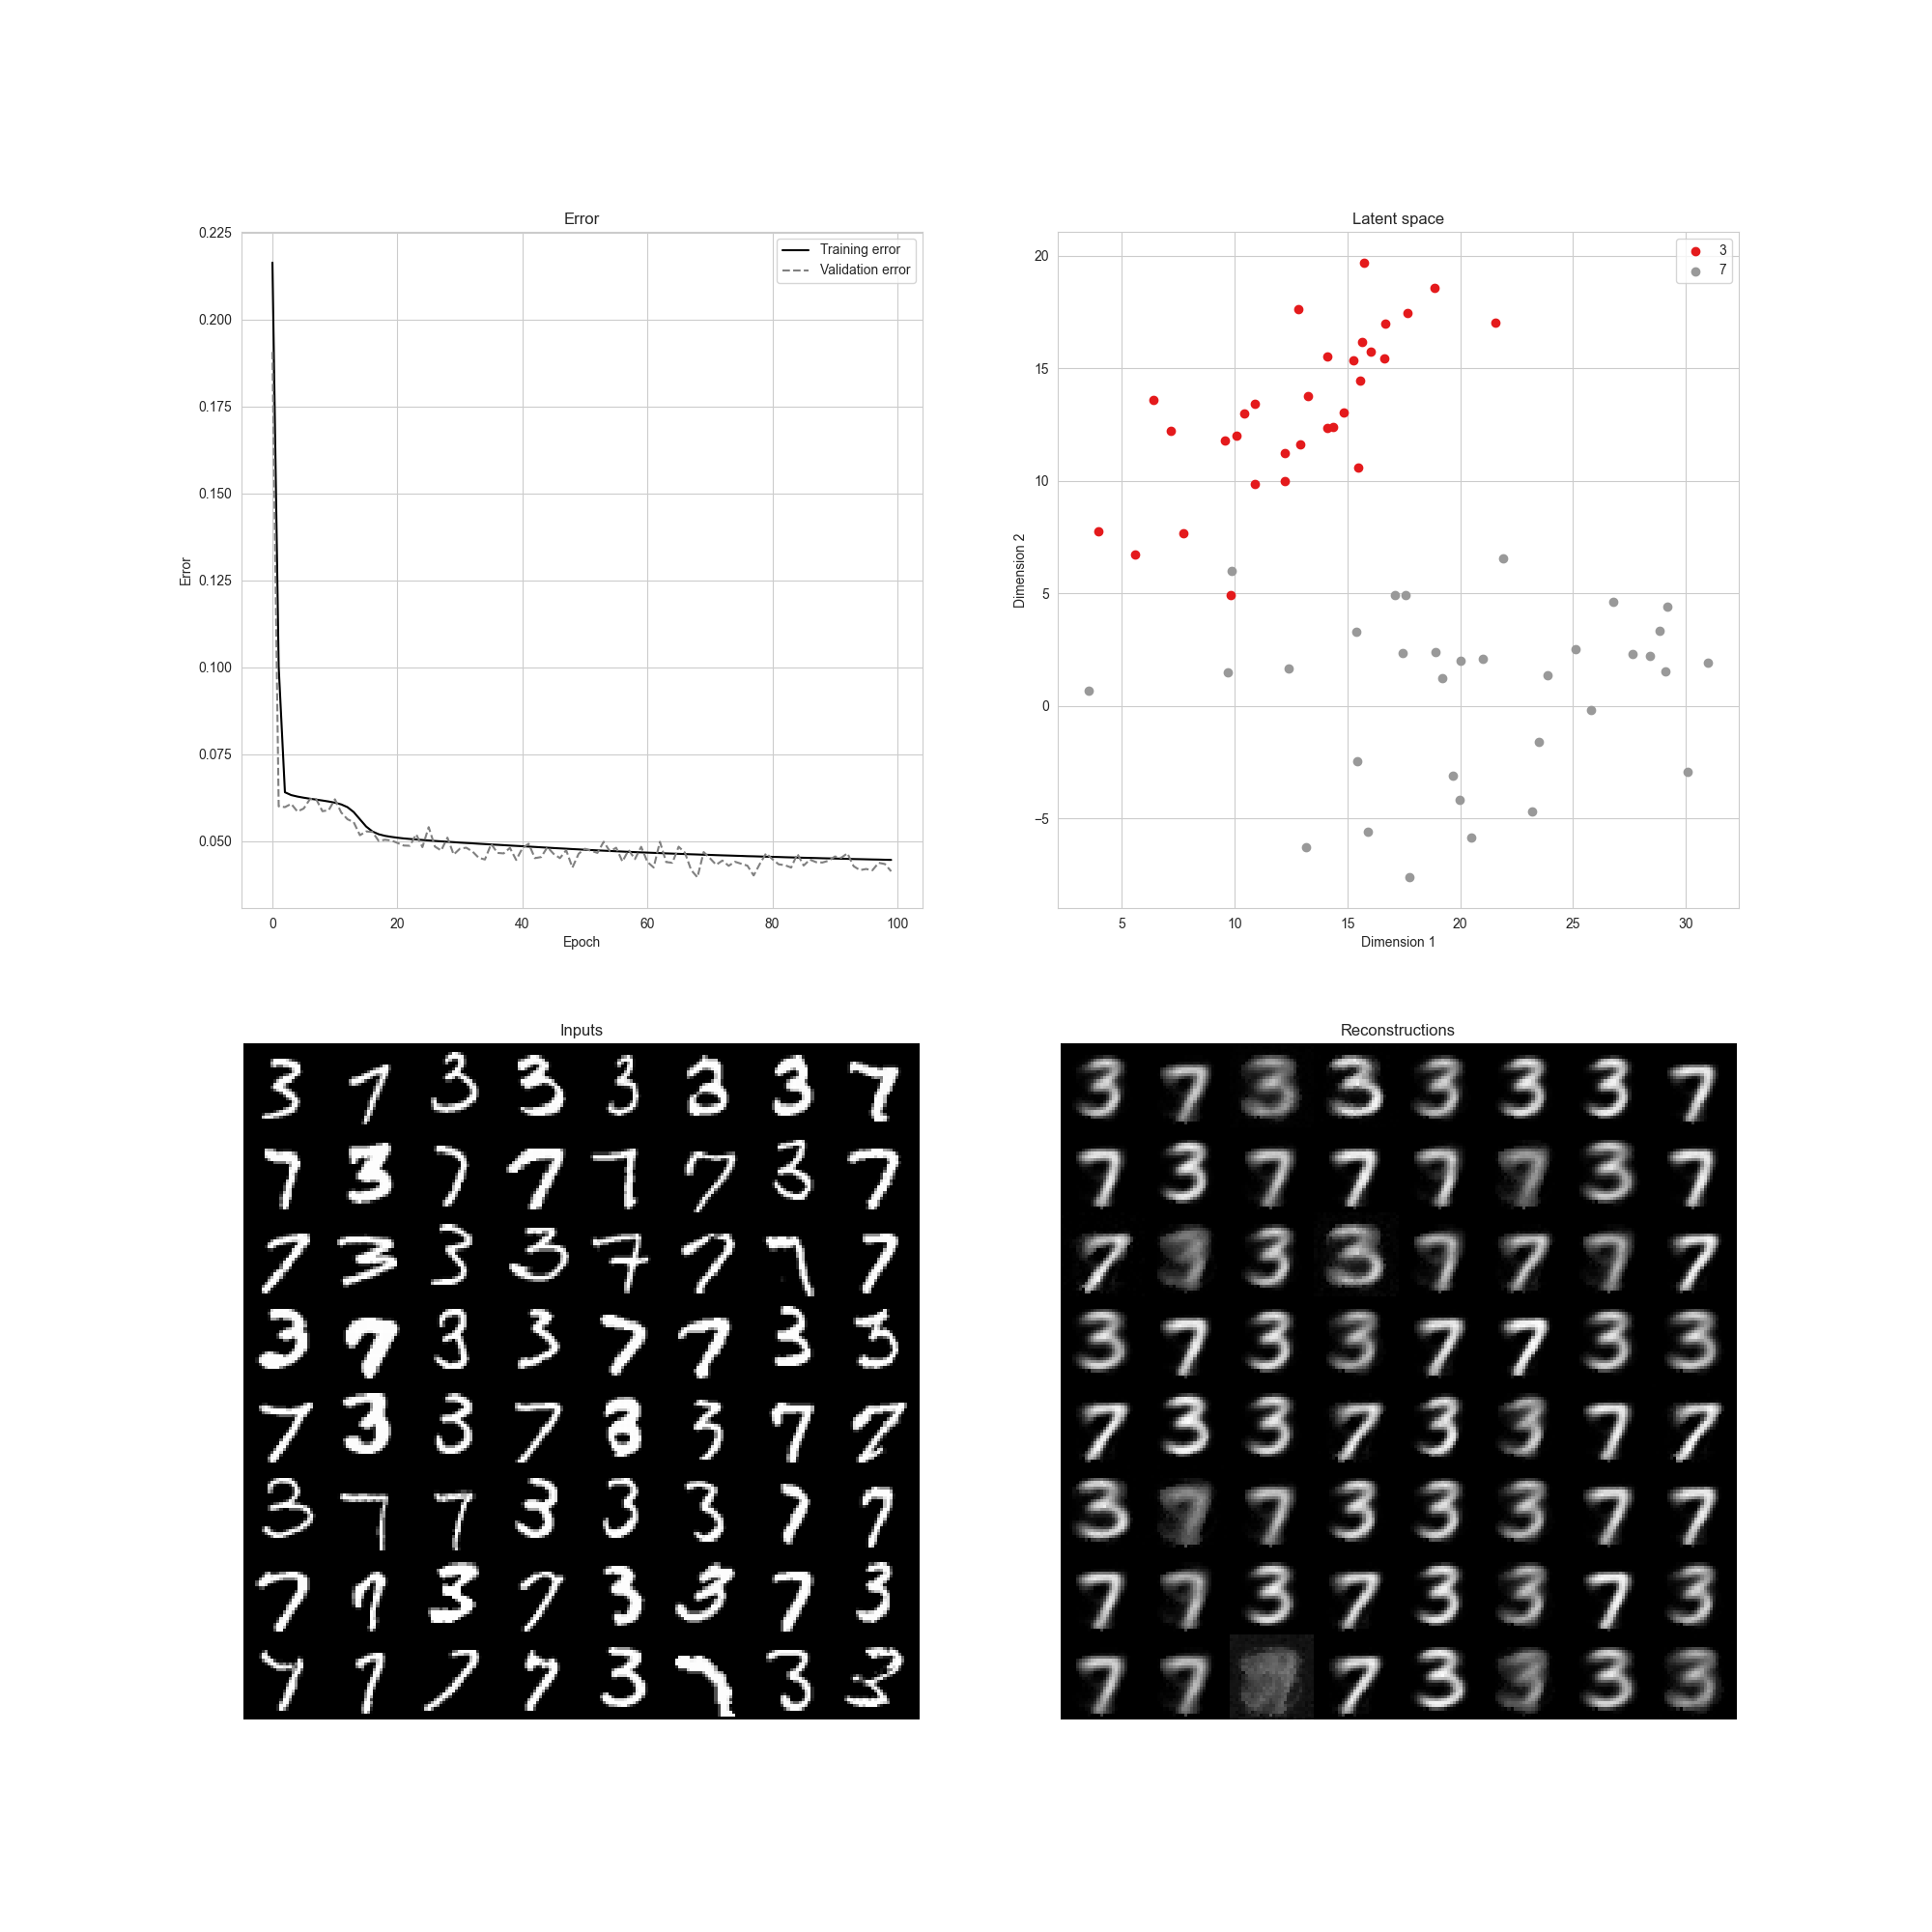

In [7]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

num_epochs = 100

train_loss = []
valid_loss = []

for epoch in range(num_epochs):
    batch_loss = []
    net.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in train_loader:
        
        if cuda:
            x = x.cuda()
        
        outputs = net(x)
        x_hat = outputs['x_hat']

        # note, target is the original tensor, as we're working with auto-encoders
        loss = loss_function(x_hat, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())

    train_loss.append(np.mean(batch_loss))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        
        if cuda:
            x = x.cuda()
        
        outputs = net(x)

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x_hat = outputs['x_hat']
        z = outputs['z'].cpu().numpy()

        loss = loss_function(x_hat, x)

        valid_loss.append(loss.item())
    
    if epoch == 0:
        continue

    # live plotting of the trainig curves and representation
    plot_autoencoder_stats(x=x.cpu(),
                           x_hat=x_hat.cpu(),
                           z=z,
                           y=y,
                           train_loss=train_loss,
                           valid_loss=valid_loss,
                           epoch=epoch,
                           classes=classes,
                           dimensionality_reduction_op=None)
    
   

# Exercises

## Exercise 1: Analyzing the AE
1. The above implementation of an AE is very simple.
    - Experiment with the number of layers and try different non-linearities in order to improve the reconstructions
    - What happens with the network when we change the non-linearities in the latent layer (e.g. sigmoid)?
    - Try to increase the number of digit classes in the training set and analyze the results
    - Test different optimization algorithms such as ADAM and RMSProp and decide whether you should use regularizers
       
2. Currently we optimize w.r.t. mean squared error. 
    - Find another error function that could fit this problem better
    - Evaluate whether the similarity function $d$ is a better choice and explain your findings

3. Complexity of the bottleneck.
    - Increase the number of units in the latent layer and train
    - Visualize by using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) or [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

## Exercises 2: Adding classification for semi-supervised learning

The above training has been performed unsupervised. Now let us assume that we only have a fraction of labeled data points from each class. As we know, semi-supervised learning can be utilized by combining unsupervised and supervised learning. Now you must analyze whether a trained AE from the above exercise can aid a classifier.

1. Build a simple classifier (like the ones from week1) where you:
    - Train on the labeled dataset and evaluate the results
2. Build a second classifier and train on the latent output $\mathbf{z}$ of the AE.
3. Build a third classifier and train on the reconstructions of the AE.
4. Evaluate the classifiers against each other and implement a model that improves the classification by combining the input, latent output, and reconstruction.

Below we provide some starting code for using only a subset of the labelled data.

In [8]:
def uniform_stratified_sampler(labels, classes, n=None):
    """
    Stratified sampler that distributes labels uniformly by
    sampling at most n data points per class
    """
    from functools import reduce
    # Only choose digits in n_labels
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))

    # Ensure uniform distribution of labels
    np.random.shuffle(indices)
    indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in classes])

    indices = torch.from_numpy(indices)
    sampler = SubsetRandomSampler(indices)
    return sampler


batch_size = 64

# Specify how many labelled examples we want per digit class
labels_per_class = 10

# Large pool of unlabelled data
unlabelled = DataLoader(dset_train, batch_size=batch_size, 
                        sampler=stratified_sampler(dset_train.train_labels, classes=classes), pin_memory=cuda)

# Smaller pool of labelled data
labelled = DataLoader(dset_train, batch_size=batch_size,
                      sampler=uniform_stratified_sampler(dset_train.train_labels, classes=classes, n=labels_per_class),
                      pin_memory=cuda)

/Users/carlahugod/Desktop/UNI/7sem/DL/02456-2025/.venv/lib/python3.13/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [9]:
from itertools import cycle

# This is an example of how you can use both the labelled
# and unlabelled loader in unison

### Define your classifier ###

num_epochs = 100
for epoch in range(num_epochs):
    
    # Go through both labelled and unlabelled data
    for (x, y), (u, _) in zip(cycle(labelled), unlabelled):
        
        if cuda:
            x, y, u = x.cuda(), y.cuda(), u.cuda()
        
        # Send labelled data through autoencoder
        outputs = net(x)

        ### Define your loss function ###
        loss = torch.nn.MSELoss()(outputs['x_hat'], x)
    
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


## Supervised classifier (labelled data only)

We train a simple MLP on the labelled subset and evaluate on the test set.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

# Reuse device and loaders if present
device = torch.device('cuda' if torch.cuda.is_available() and 'cuda' in globals() and cuda else 'cpu')
print('Device:', device)

num_classes = 10
input_dim = 28*28  # MNIST

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

clf = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(clf.parameters(), lr=1e-3)

# Prefer an existing 'labelled' DataLoader; fallback to train_loader
train_dl = labelled if 'labelled' in globals() else train_loader
assert train_dl is not None, 'No labelled or train_loader DataLoader found.'

epochs_cls = 10
for epoch in range(1, epochs_cls+1):
    clf.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = clf(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    print(f"Epoch {epoch}: loss={running_loss/total:.4f}, acc={correct/total:.4f}")

Device: cpu
Epoch 1: loss=2.3028, acc=0.0000
Epoch 2: loss=2.1515, acc=0.9000
Epoch 3: loss=1.9912, acc=0.9500
Epoch 4: loss=1.7962, acc=0.9500
Epoch 5: loss=1.5675, acc=0.9500
Epoch 6: loss=1.3119, acc=0.9500
Epoch 7: loss=1.0498, acc=0.9500
Epoch 8: loss=0.8066, acc=0.9500
Epoch 9: loss=0.6019, acc=0.9500
Epoch 10: loss=0.4437, acc=0.9500


In [11]:
# Evaluate on test set (no external deps required)
import numpy as np

clf.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = clf(x)
        preds = logits.argmax(dim=1).cpu()
        y_true.extend(y.numpy().tolist())
        y_pred.extend(preds.numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
acc = (y_true == y_pred).mean()
print(f"Test accuracy: {acc:.4f}")

# Per-class accuracy
num_classes_eval = int(y_true.max()) + 1
for c in range(num_classes_eval):
    mask = (y_true == c)
    if mask.sum() > 0:
        cls_acc = (y_pred[mask] == c).mean()
        print(f"Class {c}: acc={cls_acc:.4f} (n={mask.sum()})")

Test accuracy: 0.9455
Class 3: acc=0.9772 (n=1010)
Class 7: acc=0.9144 (n=1028)


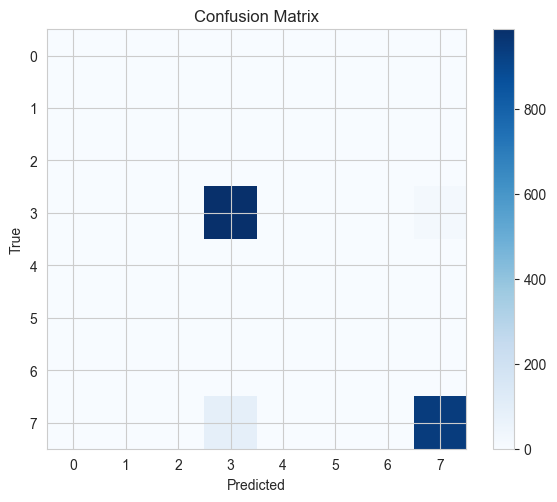

In [12]:
# Optional: confusion matrix plot (falls back if seaborn missing)
import numpy as np
import matplotlib.pyplot as plt

K = int(max(y_true.max(), y_pred.max()) + 1)
cm = np.zeros((K, K), dtype=int)
for t, p in zip(y_true, y_pred):
    cm[t, p] += 1

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.tight_layout()
plt.show()

### Classifier on AE latent representation z
We freeze the autoencoder and train a small MLP on the 2D latent `z` produced by `net.encoder(x)`.

In [13]:
import torch
import torch.nn as nn
from torch.optim import Adam

# Ensure AE in eval and frozen for feature extraction
net.eval()
for p in net.parameters():
    p.requires_grad = False

latent_dim = 2  # as defined earlier for AE
num_classes_lat = len(classes) if 'classes' in globals() else 10

# Mapping between original MNIST labels (e.g., 3,7) and local indices [0..C-1]
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

def to_local(y):
    # Map tensor of original labels to local indices
    return torch.tensor([class_to_idx[int(v)] for v in y.cpu().numpy()], device=y.device)

class ZClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes_lat)
        )
    def forward(self, z):
        return self.net(z)

clf_z = ZClassifier().to(device)
crit_z = nn.CrossEntropyLoss()
opt_z = Adam(clf_z.parameters(), lr=1e-3)

def extract_z(batch_x):
    with torch.no_grad():
        out = net.encoder(batch_x)
    return out

epochs_z = 10
for epoch in range(1, epochs_z+1):
    clf_z.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in labelled if 'labelled' in globals() else train_loader:
        x, y = x.to(device), y.to(device)
        z = extract_z(x)
        logits = clf_z(z)
        y_loc = to_local(y)
        loss = crit_z(logits, y_loc)
        opt_z.zero_grad()
        loss.backward()
        opt_z.step()
        loss_sum += loss.item() * x.size(0)
        pred_loc = logits.argmax(1)
        correct += (pred_loc == y_loc).sum().item()
        total += y.size(0)
    print(f"[z] Epoch {epoch}: loss={loss_sum/total:.4f}, acc={correct/total:.4f}")

# Test on test_loader
clf_z.eval()
y_true_z, y_pred_z = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        z = extract_z(x)
        logits = clf_z(z)
        pred_loc = logits.argmax(1).cpu().numpy().tolist()
        y_pred_z.extend([idx_to_class[i] for i in pred_loc])
        y_true_z.extend(y.numpy().tolist())
print('Latent z classifier ready.')

[z] Epoch 1: loss=10.5470, acc=0.5000
[z] Epoch 2: loss=9.9939, acc=0.5000
[z] Epoch 3: loss=9.4414, acc=0.5000
[z] Epoch 4: loss=8.8894, acc=0.5000
[z] Epoch 5: loss=8.3384, acc=0.5000
[z] Epoch 6: loss=7.7882, acc=0.5000
[z] Epoch 7: loss=7.2387, acc=0.5000
[z] Epoch 8: loss=6.6899, acc=0.5000
[z] Epoch 9: loss=6.1414, acc=0.5000
[z] Epoch 10: loss=5.5933, acc=0.5000
Latent z classifier ready.
Latent z classifier ready.


### Classifier on AE reconstructions x_hat
We pass inputs through the AE decoder and train a classifier on reconstructed images.

In [14]:
class XHatClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, len(classes) if 'classes' in globals() else 10)
        )
    def forward(self, xhat):
        return self.net(xhat)

clf_xhat = XHatClassifier().to(device)
crit_xhat = nn.CrossEntropyLoss()
opt_xhat = Adam(clf_xhat.parameters(), lr=1e-3)

def reconstruct(batch_x):
    with torch.no_grad():
        out = net(batch_x)
        x_hat_batch = out['x_hat']
    return x_hat_batch

epochs_xhat = 10
for epoch in range(1, epochs_xhat+1):
    clf_xhat.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in labelled if 'labelled' in globals() else train_loader:
        x, y = x.to(device), y.to(device)
        xhat = reconstruct(x)
        logits = clf_xhat(xhat)
        y_loc = to_local(y)
        loss = crit_xhat(logits, y_loc)
        opt_xhat.zero_grad()
        loss.backward()
        opt_xhat.step()
        loss_sum += loss.item() * x.size(0)
        pred_loc = logits.argmax(1)
        correct += (pred_loc == y_loc).sum().item()
        total += y.size(0)
    print(f"[x_hat] Epoch {epoch}: loss={loss_sum/total:.4f}, acc={correct/total:.4f}")

# Test on test_loader
clf_xhat.eval()
y_true_xhat, y_pred_xhat = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        xhat = reconstruct(x)
        logits = clf_xhat(xhat)
        pred_loc = logits.argmax(1).cpu().numpy().tolist()
        y_pred_xhat.extend([idx_to_class[i] for i in pred_loc])
        y_true_xhat.extend(y.numpy().tolist())
print('Reconstruction x_hat classifier ready.')

[x_hat] Epoch 1: loss=0.6913, acc=0.5000
[x_hat] Epoch 2: loss=0.6408, acc=0.9500
[x_hat] Epoch 3: loss=0.5904, acc=0.9500
[x_hat] Epoch 4: loss=0.5328, acc=0.9500
[x_hat] Epoch 5: loss=0.4705, acc=0.9500
[x_hat] Epoch 6: loss=0.4042, acc=0.9500
[x_hat] Epoch 7: loss=0.3393, acc=0.9500
[x_hat] Epoch 8: loss=0.2809, acc=0.9500
[x_hat] Epoch 9: loss=0.2337, acc=0.9500
[x_hat] Epoch 10: loss=0.1994, acc=0.9500
Reconstruction x_hat classifier ready.
Reconstruction x_hat classifier ready.


### Evaluate and combine classifiers
We compare accuracy for: input-based classifier (clf), latent-based (clf_z), reconstruction-based (clf_xhat). Then combine via simple averaging of logits.

In [15]:
import numpy as np

# Ensure class mappings exist
if 'class_to_idx' not in globals():
    class_to_idx = {c: i for i, c in enumerate(classes)}
    idx_to_class = {i: c for c, i in class_to_idx.items()}


def accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return (y_true == y_pred).mean()

# Ensure base clf exists; if not, create a quick one on inputs
if 'clf' not in globals():
    class InputClassifier(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Flatten(),
                nn.Linear(num_features, 256), nn.ReLU(),
                nn.Linear(256, 128), nn.ReLU(),
                nn.Linear(128, 10)  # full MNIST space
            )
        def forward(self, x):
            return self.net(x)
    clf = InputClassifier().to(device)

# Evaluate all three on test set
clf.eval(); clf_z.eval(); clf_xhat.eval()
y_true_all, y_pred_input, y_pred_lat, y_pred_xhat, y_pred_ens = [], [], [], [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        # input (10-class)
        logits_in = clf(x)  # [B,10]
        # map to local class index space by selecting digits in `classes`
        cols = torch.tensor(classes, device=logits_in.device, dtype=torch.long)
        logits_in_local = logits_in.index_select(1, cols)  # [B, C]

        # z (already local class space [0..C-1])
        z = net.encoder(x)
        logits_z = clf_z(z)
        # x_hat (already local class space [0..C-1])
        xhat = torch.sigmoid(net.decoder(z))
        logits_xhat = clf_xhat(xhat)

        # predictions in original label space
        pred_in_loc = logits_in_local.argmax(1).cpu().numpy().tolist()
        pred_z_loc = logits_z.argmax(1).cpu().numpy().tolist()
        pred_xhat_loc = logits_xhat.argmax(1).cpu().numpy().tolist()
        pred_in = [idx_to_class[i] for i in pred_in_loc]
        pred_z = [idx_to_class[i] for i in pred_z_loc]
        pred_xhat = [idx_to_class[i] for i in pred_xhat_loc]

        # ensemble (avg logits in the local class space, then map back)
        logits_avg = (logits_in_local + logits_z + logits_xhat) / 3.0
        pred_ens_loc = logits_avg.argmax(1).cpu().numpy().tolist()
        pred_ens = [idx_to_class[i] for i in pred_ens_loc]

        y_true_all.extend(y.numpy().tolist())
        y_pred_input.extend(pred_in)
        y_pred_lat.extend(pred_z)
        y_pred_xhat.extend(pred_xhat)
        y_pred_ens.extend(pred_ens)

print(f"Acc input: {accuracy(y_true_all, y_pred_input):.4f}")
print(f"Acc latent z: {accuracy(y_true_all, y_pred_lat):.4f}")
print(f"Acc recon x_hat: {accuracy(y_true_all, y_pred_xhat):.4f}")
print(f"Acc ensemble (avg logits): {accuracy(y_true_all, y_pred_ens):.4f}")

Acc input: 0.9455
Acc latent z: 0.4956
Acc recon x_hat: 0.9441
Acc ensemble (avg logits): 0.4990


## Tuning labelled vs unlabelled proportions

We build helper functions to control the amount of labelled data per class and the fraction of unlabelled data, then run a small grid search to find the best mix.

In [16]:
from torch.utils.data import DataLoader, Subset

# Handles different attribute names across torchvision versions
train_targets = getattr(dset_train, 'targets', None)
if train_targets is None:
    train_targets = getattr(dset_train, 'train_labels')

test_targets = getattr(dset_test, 'targets', None)
if test_targets is None:
    test_targets = getattr(dset_test, 'test_labels')

classes = classes  # ensure visibility

def build_labelled_unlabelled_loaders(labels_per_class=10, unlabeled_fraction=1.0, batch_size=64, shuffle=False):
    """
    Create labelled and unlabelled DataLoaders.
    - labels_per_class: number of labelled samples per class in `classes`.
    - unlabeled_fraction: fraction of remaining in-class samples to include as unlabelled.
    Ensures labelled indices are excluded from unlabelled.
    """
    # collect indices per class
    idx_by_class = {c: (train_targets == c).nonzero(as_tuple=False).view(-1).cpu().numpy() for c in classes}

    # labelled indices: first k per class (after shuffling for randomness)
    labelled_idx = []
    rng = np.random.default_rng(42)
    for c in classes:
        idxs = idx_by_class[c]
        rng.shuffle(idxs)
        labelled_idx.extend(idxs[:labels_per_class])

    labelled_set = Subset(dset_train, labelled_idx)

    # unlabelled indices: remaining indices from selected classes, sample a fraction
    remaining = []
    for c in classes:
        idxs = idx_by_class[c]
        rem = [i for i in idxs if i not in set(labelled_idx)]
        remaining.extend(rem)
    rng.shuffle(remaining)
    take = int(len(remaining) * float(unlabeled_fraction))
    unlabelled_idx = remaining[:take]
    unlabelled_set = Subset(dset_train, unlabelled_idx)

    labelled_loader = DataLoader(labelled_set, batch_size=batch_size, shuffle=shuffle, pin_memory=cuda)
    unlabelled_loader = DataLoader(unlabelled_set, batch_size=batch_size, shuffle=shuffle, pin_memory=cuda)
    return labelled_loader, unlabelled_loader

# Quick smoke test
lbl_tmp, unlbl_tmp = build_labelled_unlabelled_loaders(labels_per_class=5, unlabeled_fraction=0.5, batch_size=64)
print(f"labelled batches: {len(lbl_tmp)}, unlabelled batches: {len(unlbl_tmp)}")

labelled batches: 1, unlabelled batches: 97


In [17]:
# Simple semi-supervised trainer: supervised CE on labelled + consistency on unlabelled via AE reconstruction
import torch.nn.functional as F

class SemiSupClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

def train_semisup(labels_per_class=10, unlabeled_fraction=1.0, epochs=5, lambda_cons=0.5, lr=1e-3, batch_size=64):
    labelled_loader, unlabelled_loader = build_labelled_unlabelled_loaders(labels_per_class, unlabeled_fraction, batch_size)
    model = SemiSupClassifier(len(classes)).to(device)
    opt = Adam(model.parameters(), lr=lr)

    # Map labels to local indices
    class_to_idx = {c: i for i, c in enumerate(classes)}
    def to_local(y):
        return torch.tensor([class_to_idx[int(v)] for v in y.cpu().numpy()], device=y.device)

    for epoch in range(1, epochs+1):
        model.train()
        sup_loss_sum, cons_loss_sum, n_sup = 0.0, 0.0, 0
        # Iterate over the shorter loader to keep epoch bounded
        for (xb_l, yb_l), (xb_u, _) in zip(labelled_loader, unlabelled_loader):
            xb_l, yb_l = xb_l.to(device), yb_l.to(device)
            xb_u = xb_u.to(device)

            # Supervised CE on labelled
            logits_l = model(xb_l)
            y_loc = to_local(yb_l)
            loss_sup = F.cross_entropy(logits_l, y_loc)

            # Consistency on unlabelled: predictions should be similar on x and x_hat
            with torch.no_grad():
                z_u = net.encoder(xb_u)
                xhat_u = torch.sigmoid(net.decoder(z_u))
            p_u = F.log_softmax(model(xb_u), dim=1)
            q_u = F.softmax(model(xhat_u), dim=1)
            loss_cons = F.kl_div(p_u, q_u, reduction='batchmean')

            loss = loss_sup + lambda_cons * loss_cons
            opt.zero_grad()
            loss.backward()
            opt.step()

            sup_loss_sum += loss_sup.item() * xb_l.size(0)
            cons_loss_sum += loss_cons.item() * xb_u.size(0)
            n_sup += xb_l.size(0)
        print(f"Epoch {epoch}: sup_loss={sup_loss_sum/max(1,n_sup):.4f}, cons_loss={cons_loss_sum/max(1,n_sup):.4f}")

    # Evaluate on test set
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_te, y_te in test_loader:
            x_te = x_te.to(device)
            logits = model(x_te)
            pred = logits.argmax(1).cpu().numpy().tolist()
            y_pred.extend([classes[i] for i in pred])
            y_true.extend(y_te.numpy().tolist())
    acc = (np.array(y_true) == np.array(y_pred)).mean()
    return acc, model

# quick test run
acc_tmp, _ = train_semisup(labels_per_class=5, unlabeled_fraction=0.5, epochs=1)
print(f"Smoke test acc: {acc_tmp:.4f}")

Epoch 1: sup_loss=0.6936, cons_loss=0.0005
Smoke test acc: 0.8749


In [18]:
# Grid search over labelled_per_class and unlabeled_fraction

label_grid = [2, 5, 10, 20]
unlabeled_grid = [0.25, 0.5, 1.0]

results = []
for lpc in label_grid:
    for uf in unlabeled_grid:
        acc, _ = train_semisup(labels_per_class=lpc, unlabeled_fraction=uf, epochs=2, lambda_cons=0.5, lr=1e-3, batch_size=64)
        results.append({'labels_per_class': lpc, 'unlabeled_fraction': uf, 'acc': float(acc)})
        print(f"lpc={lpc}, ufrac={uf} -> acc={acc:.4f}")

# Find best
best = max(results, key=lambda r: r['acc'])
print("\nBest setting:")
print(best)

# Optional: pretty table
try:
    import pandas as pd
    df = pd.DataFrame(results)
    display(df.pivot(index='labels_per_class', columns='unlabeled_fraction', values='acc'))
except Exception as e:
    print("Install pandas to see a pivot table.")

Epoch 1: sup_loss=0.6772, cons_loss=0.0020
Epoch 2: sup_loss=0.5975, cons_loss=0.0055
lpc=2, ufrac=0.25 -> acc=0.9328
Epoch 1: sup_loss=0.6865, cons_loss=0.0010
Epoch 2: sup_loss=0.6080, cons_loss=0.0038
lpc=2, ufrac=0.5 -> acc=0.9230
Epoch 1: sup_loss=0.6949, cons_loss=0.0010
Epoch 2: sup_loss=0.6153, cons_loss=0.0039
lpc=2, ufrac=1.0 -> acc=0.8651
Epoch 1: sup_loss=0.7055, cons_loss=0.0008
Epoch 2: sup_loss=0.6304, cons_loss=0.0014
lpc=5, ufrac=0.25 -> acc=0.9028
Epoch 1: sup_loss=0.6949, cons_loss=0.0010
Epoch 2: sup_loss=0.6153, cons_loss=0.0039
lpc=2, ufrac=1.0 -> acc=0.8651
Epoch 1: sup_loss=0.7055, cons_loss=0.0008
Epoch 2: sup_loss=0.6304, cons_loss=0.0014
lpc=5, ufrac=0.25 -> acc=0.9028
Epoch 1: sup_loss=0.6932, cons_loss=0.0007
Epoch 2: sup_loss=0.6130, cons_loss=0.0018
lpc=5, ufrac=0.5 -> acc=0.9446
Epoch 1: sup_loss=0.6868, cons_loss=0.0006
Epoch 2: sup_loss=0.6044, cons_loss=0.0022
lpc=5, ufrac=1.0 -> acc=0.9450
Epoch 1: sup_loss=0.6932, cons_loss=0.0007
Epoch 2: sup_loss=

unlabeled_fraction,0.25,0.50,1.00
labels_per_class,,,
2,0.932777,0.922964,0.865064
5,0.902846,0.944553,0.945044
10,0.866536,0.783121,0.947007
20,0.953876,0.649166,0.954367
